<a href="https://colab.research.google.com/github/wenzhenghe7/web_scraping/blob/main/douban_scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import time
import urllib.request, urllib.parse, urllib.error
import urllib.request, urllib.error, urllib.parse
import numpy as np
from bs4 import BeautifulSoup
from openpyxl import Workbook
import importlib
import ssl
import string
ssl._create_default_https_context = ssl._create_unverified_context

importlib.reload(sys)

header = {
    "User-Agent":
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36",
    'cookie':
    'AJi4QfFtds5U6MgYboMmrpNeGXPfBWaOK1JivVd12GFbrpuktxQWIW6GAHC_V1NMcMsDE0-Odvk'
}



In [66]:
def book_spider(book_tag, rating_limit = 9.0, com_limit = 50):
    page_num = 0
    book_list = []
    try_times = 0

    while (1):
        # url = 'https://book.douban.com/tag/%E7%BC%96%E7%A8%8B?start=0' # 测试 url
        url = 'https://book.douban.com/tag/' + urllib.parse.quote(
            book_tag) + '?start=' + str(page_num * 20)
        time.sleep(np.random.rand() * 4)
        try:
            # 代理 ip

            # ip_list = testgkb.get_ip_list(url_ip, headers=header)
            # proxies = testgkb.get_random_ip(ip_list)
            # # proxy = random.choice(proxy_list)
            # httpproxy_handler = urllib.request.ProxyHandler(proxies)
            # opener = urllib.request.build_opener(httpproxy_handler)
            # urllib.request.install_opener(opener)
            req = urllib.request.Request(url, headers=header)
            # req = opener.open(req0)
            source_code = urllib.request.urlopen(req).read().decode('utf-8')
            plain_text = str(source_code)
        except (urllib.error.HTTPError, urllib.error.URLError) as e:
            print(e)
            continue

        soup = BeautifulSoup(plain_text)
        # print(soup)
        list_soup = soup.find('ul', {'class': 'subject-list'})
        try_times += 1
        if list_soup == None and try_times < 200:
            continue
        elif list_soup == None or len(list_soup) <= 1:
            break  # Break when no informatoin got after 200 times requesting

        for book_info in list_soup.findAll('div', {'class': 'info'}):
            # print(book_info)
            title = ''.join(list(book_info.find('a').stripped_strings))
            desc = book_info.find('div', {'class': 'pub'}).string.strip()
            desc_list = desc.split('/')
            link = book_info.find('a')['href']
            try:
                author_info = '' + '/'.join(desc_list[0:-3])
            except:
                author_info = '作者/译者: 暂无'
            try:
                pub_info = '' + '/'.join(desc_list[-3:])
            except:
                pub_info = '出版信息： 暂无'
            try:
                rating = book_info.find('span', {
                    'class': 'rating_nums'
                }).string.strip()
            except:
                rating = '0.0'
            if float(rating) < rating_limit:
              continue
            try:
                people_num = book_info.find('span', {
                    'class': 'pl'
                }).string.strip()
                people_num = people_num.strip('(')
                people_num = people_num.strip(')')
                people_num = people_num.strip('少于')
                people_num = people_num.strip('目前无')
                people_num = people_num.strip('人评价')
                # print(people_num)
            except:
                people_num = '0'
            if float(people_num) < com_limit:
              continue
            book_list.append(
                [title, rating, people_num, author_info, pub_info,link])
            try_times = 0  # set 0 when got valid information
        page_num += 1
        print('Downloading Information From Page %d' % page_num)
    return book_list

def do_spider(book_tag_lists,rating_limit = 9.0, com_limit = 50):
    book_lists = []
    for book_tag in book_tag_lists:
        book_list = book_spider(book_tag, rating_limit, com_limit)
        book_list = sorted(book_list, key=lambda x: x[1], reverse=True)
        book_lists.append(book_list)
    return book_lists


def print_book_lists_excel(book_lists, book_tag_lists):
    wb = Workbook(write_only=True)
    ws = []
    for i in range(len(book_tag_lists)):
        ws.append(wb.create_sheet(title=book_tag_lists[i]))  #utf8->unicode
    for i in range(len(book_tag_lists)):
        ws[i].append(['序号', '书名', '评分', '评价人数', '作者/译者', '出版社', '链接'])
        count = 1
        for bl in book_lists[i]:
            ws[i].append(
                [count, bl[0],
                 float(bl[1]),
                 str(bl[2]), bl[3], bl[4], bl[5]])
            count += 1
    if len(book_tag_lists) > 1:
        ws.append(wb.create_sheet(title='&'.join(book_tag_lists)))
        combine_tab = len(book_tag_lists)
        ws[combine_tab].append(['序号', '书名', '评分', '评价人数', '作者/译者', '出版社', '链接'])
        count = 1
        link_tracking = []
        for i in range(len(book_tag_lists)):
          for bl in book_lists[i]:
            if bl[5] in link_tracking:
              continue
            else:
              link_tracking.append(bl[5])
              ws[combine_tab].append(
                [count, bl[0],
                 float(bl[1]),
                 str(bl[2]), bl[3], bl[4], bl[5]])
              count += 1
    count = 1
    save_path = 'book_list'
    for i in range(len(book_tag_lists)):
        save_path += ('-' + book_tag_lists[i])
    save_path += '.xlsx'
    wb.save(save_path)


In [67]:
# if __name__ == '__main__':
   
    # book_tag_lists = ['算法', '互联网']
    # book_tag_lists = ['经济学', '管理', '金融']
    # book_tag_lists = ['python']
    # book_tag_lists = ['编程']
    # book_tag_lists = ['传记', '哲学', '编程', '创业', '理财', '社会学', '佛教']
    # book_tag_lists = ['思想', '科技', '科学', 'web', '股票', '爱情', '两性']
    # book_tag_lists = ['编程', '机器学习', 'linux', '数据库', '互联网']
    # book_tag_lists = ['计算机', '机器学习', 'linux', 'android', '数据库', '互联网']
    # book_tag_lists = ['摄影', '设计', '音乐', '旅行', '教育', '成长', '情感', '育儿', '健康', '养生'
    # book_tag_lists = ['商业', '理财', '管理']
    # book_tag_lists = ['科普', '经典', '生活', '心灵', '文学']

book_tag_lists = ['心理学','心理']
book_lists = do_spider(book_tag_lists, 9, 50)
print_book_lists_excel(book_lists, book_tag_lists)

In [70]:
book_tag_lists = ['职场']
book_lists = do_spider(book_tag_lists, 8.5, 50)
print_book_lists_excel(book_lists, book_tag_lists)

In [44]:
comment_num = np.array([int(i[2]) for i in book_lists[0] if float(i[1]) >= 8.0 and float(i[2]) > 50])
rating = np.array([float(i[1]) for i in book_lists[0] if float(i[1]) >= 8.0 and float(i[2]) > 50])

In [57]:
selection = comment_num < 20000

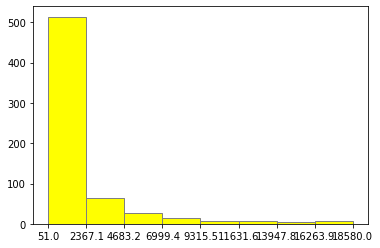

In [58]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
# x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(comment_num[selection], facecolor='yellow', edgecolor='gray',bins = 8)

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))


In [ ]:
plt.plot(comment_num[selection], rating, 'o', color='black');